# Classification of text documents using sparse features

This example uses a Tf-idf-weighted document-term sparse matrix to encode the features and demonstrates various classifiers that can efficiently handle sparse matrices.

## Loading and vectorizing the 20 newsgroups text dataset

**fetch_20newsgroups** function load data, 18,000 newsgroups posts on 20 topics split in two **subsets**: one for training (or development) and the other one for testing (or for performance evaluation).  Note that, by default, the text samples contain **some message metadata** such as 'headers', 'footers' (signatures) and 'quotes' to other posts. The fetch_20newsgroups function therefore accepts a parameter named **remove** to attempt stripping such information that can make the classification problem “too easy”. 

In [49]:
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

# example : docs["hello", "world"]
def size_mb(docs):
    return sum( len(s.encode("utf-8")) for s in docs) / 1e6

#
def load_dataset(verbose=False, remove=()):
    """ load and vectorize the 20 newsgroups dataset. """
    data_train = fetch_20newsgroups(
        subset="train",
        categories= categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )
    data_test = fetch_20newsgroups(
        subset="test",
        categories= categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )
    # order of lables in targer_names can be different from categories
    target_names = data_train.target_names

    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer( # ❓
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0 # ❓
    
    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0
    
    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size mb of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(
            f"{len(data_test.data)} documents - "
            f"{data_test_size_mb:.2f}MB (test set)"
        )
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train : .3f}MB/s"
        )
        print(
            f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}"
        )
        print(
            f"vectorize test done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test :.3f}MB/s"
        )
        print(
            f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}"
        )
    return X_train,X_test, y_train, y_test, feature_names, target_names


In [50]:
X_train,X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
vectorize training done in 0.940s at  4.232MB/s
n_samples: 2034, n_features: 7831
vectorize test done in 0.574s at 4.992MB/s
n_samples: 1353, n_features: 7831


## RidgeClassfier
Contrary to LogisticRegression, RidgeClassifier does not provide probabilistic predictions (no predict_proba method), but it is often faster to train.

In [51]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier(tol=1e-2, solver="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)


We plot the confusion matrix of this classifier to **find if there is a pattern** in the classification errors.

Text(0.5, 1.0, 'Confusion matrix for RidgeClassifier\n on the original documents')

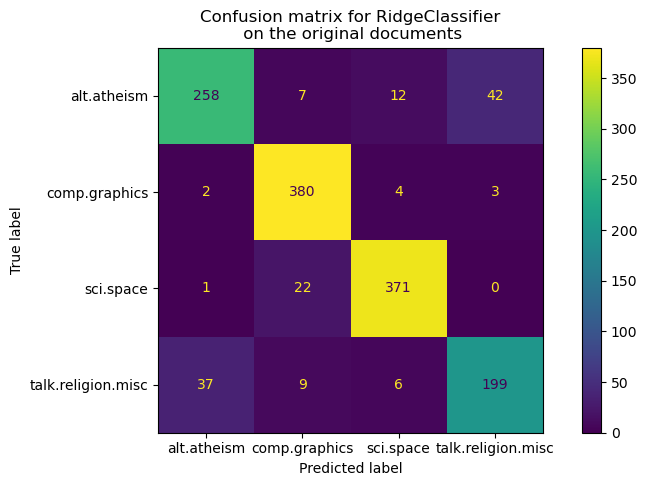

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize = (10,5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax = ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
ax.set_title(
    f"Confusion matrix for {clf.__class__.__name__}\n on the original documents"
)

🔍 Manual Observation
- documents of the alt.atheism class are often confused with documents with the class talk.religion.misc class.  And vice-versa
- documents of the sci.space class can be misclassified as comp.graphics while the converse is much rarer.  But converse is much rarer

We can gain a deeper understanding of how this classifier makes its decisions **by looking at the words with the highest average feature effects.** For example, some words might have strong positive/negtive effects on a category.

top5 keywords per class: 
   alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


<Axes: title={'center': 'Aeverage-feature effect on the original data'}, xlabel='average-feature effect value', ylabel='feature name'>

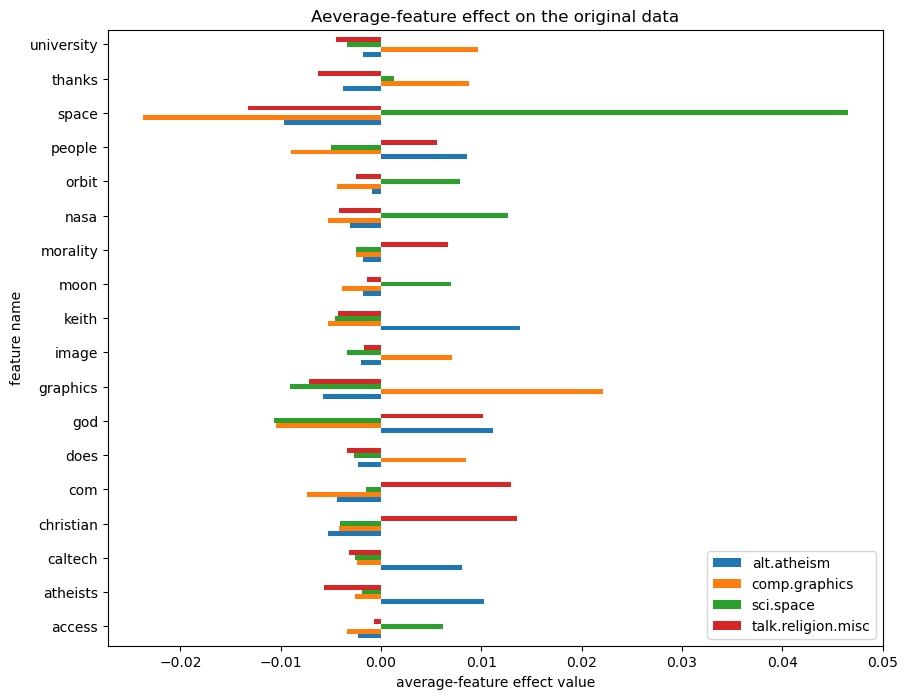

In [53]:
import numpy as np
import pandas as pd

def plot_feature_effects():
    # weight * feature_avg
    # This represents the average contribution of each feature to the clssifier's decision
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0))
    #print(X_train.shape,clf.coef_.shape, y_train.shape, average_feature_effects.shape)

    # stat every target top5 feature contribution.
    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns = [label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]
    #print(top)

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)
    fig, ax = plt.subplots(figsize=(10,8))
    for i, label in enumerate(target_names):
        ax.barh( # horizontal chart
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks = y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4*bar_size,
            len(top_indices)*(4*bar_size + padding) - 4*bar_size
        ]
    )
    ax.legend(loc="lower right")
    ax.set_xlabel("average-feature effect value")
    ax.set_ylabel("feature name")
    print("top5 keywords per class: \n", top)
    return ax
plot_feature_effects().set_title("Aeverage-feature effect on the original data")


📊
- We can observe that most keywords are often **strongly** positively or negtively with a single class. And it's easy to interpret. However, some not. Such as "god", there are two classes.
- Furthermore, in this version of the dataset, such as 'caltech' , the word is the top5 feature for atheism due to **pollution** in the dataset coming from some metadata such as email addr.

In [54]:
data_train = fetch_20newsgroups(
    subset="train",
    categories= categories,
    shuffle=True,
    random_state=42,
)
for doc in data_train.data:
    if 'caltech' in doc: # keith@cco.caltech.edu 
        print(doc)
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

✅
- Meta info is only side information.
- one would rather want our text classifier to only learn from the “main content” of each text document instead of relying on the leaked identity of the writers.


## Model with meta stripping


Text(0.5, 1.0, 'Confusion matrix for RidgeClassifier\n on filter docuements')

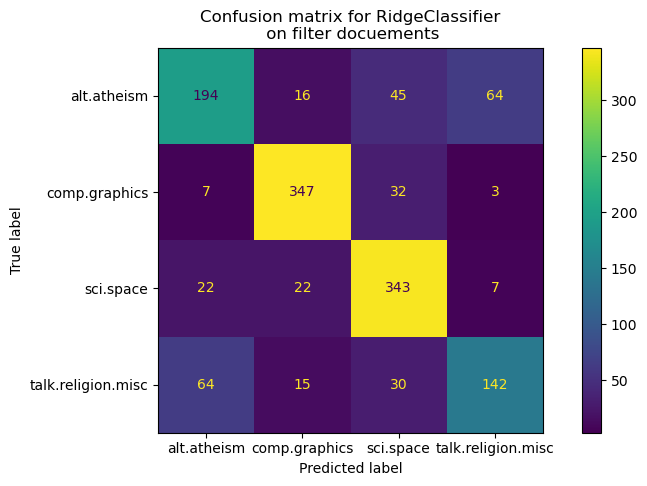

In [57]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))
clf = RidgeClassifier(tol=1e-2, solver="auto")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
ax.set_title(
    f"Confusion matrix for {clf.__class__.__name__}\n on filter docuements"
)

top5 keywords per class: 
   alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


Text(0.5, 1.0, 'Aeverage-feature effect on the filtered data')

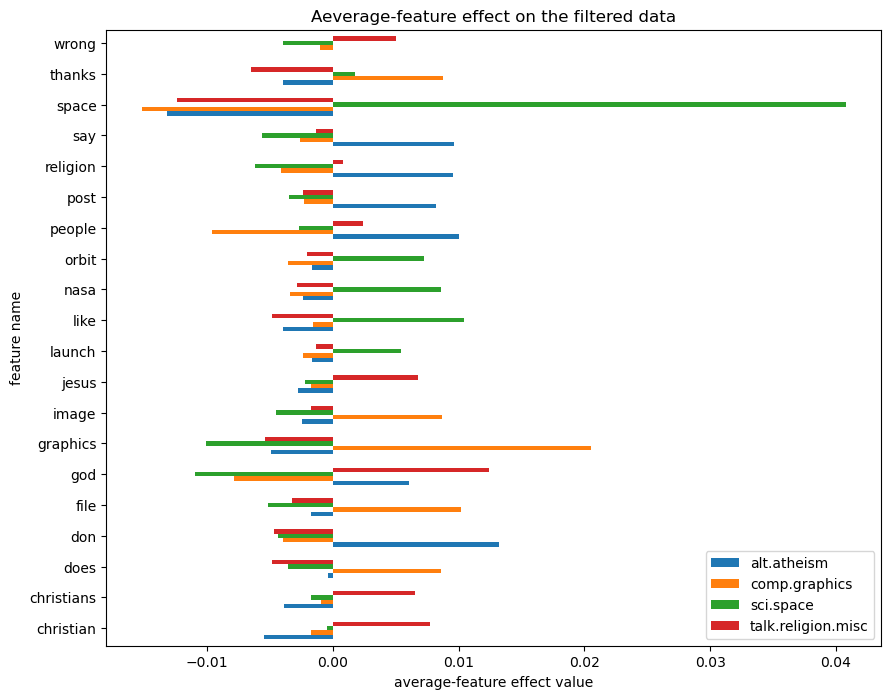

In [58]:
plot_feature_effects().set_title("Aeverage-feature effect on the filtered data")
